In [1]:
import time
import numpy as np
from PIL import Image
import sys
import glob
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import cv2
import re

In [2]:
def pcp(M, convergence_rate, mu, maxiter=500):


    # Check for missing data.
    shape = M.shape
  
    missing = ~(np.isfinite(M))
    if np.any(missing):
          M = np.array(M)
          M[missing] = 0.0

    lam = 1.0 / np.sqrt(np.max(shape))

    norm = np.sum(M ** 2)

    # Iterate.
    i = 0
    rank = np.min(shape)
    S = np.zeros(shape)
    Y = np.zeros(shape)

    for i in range(maxiter):
        
        # start time
        start = time.time()

        # SVD step.
        u ,s ,v = np.linalg.svd(M - S + Y / mu, full_matrices=False)
  

        s = shrink(s, 1./mu)
        rank = np.sum(s > 0.0)
        u, s, v = u[:, :rank], s[:rank], v[:rank, :]
        L = np.dot(u, np.dot(np.diag(s), v))

        # Shrinkage step.
        S = shrink(M - L + Y / mu, lam / mu)

        # Lagrange step.
        step = M - L - S
        step[missing] = 0.0
        Y += mu * step

        #calc error
        error = np.sqrt(np.sum(step ** 2) / norm)

        #stop time
        iter_time = time.time() - start
        
        print(f"ITERATION -- {i}: error -- {error}, rank -- {rank}, time -- {iter_time} ")

        # check if converge
        if error < convergence_rate:
            break

        i += 1

    return L, S


def shrink(M, tau):
    sgn = np.sign(M)
    S = np.abs(M) - tau
    S[S < 0.0] = 0.0
    return sgn * S

In [3]:
def bitmap_to_mat(bitmap_seq):
    """from blog.shriphani.com"""
    matrix = []
    shape = None
    for bitmap_file in bitmap_seq:
        img = Image.open(bitmap_file).convert("L")
        if shape is None:
            shape = img.size
        assert img.size == shape
        img = np.array(img.getdata())
        matrix.append(img)
    return np.array(matrix), shape[::-1]

# RUN PCP
### 1 iter ~ 30sec
### dataset in the 'images' folder

In [4]:
M, shape = bitmap_to_mat(glob.glob("images/*.bmp"))
M.shape

(500, 86400)

In [5]:
 mu = 0.25 * np.prod(M.shape) / np.sum(np.abs(M))
 mu

0.001786697691745648

In [7]:
L, S = pcp(M, 1e-6,mu, maxiter=15)

ITERATION -- 0: error -- 0.006760144682224086, rank -- 500, time -- 19.750088214874268 
ITERATION -- 1: error -- 0.0014893348749170387, rank -- 500, time -- 19.27698516845703 
ITERATION -- 2: error -- 0.0011090894521204357, rank -- 500, time -- 20.079668521881104 
ITERATION -- 3: error -- 0.0010073986287510678, rank -- 500, time -- 19.43633770942688 
ITERATION -- 4: error -- 0.0009565561378377555, rank -- 500, time -- 19.26932716369629 
ITERATION -- 5: error -- 0.0009128175731325758, rank -- 500, time -- 20.223217964172363 
ITERATION -- 6: error -- 0.0008702402689565112, rank -- 500, time -- 19.51477551460266 
ITERATION -- 7: error -- 0.0008284189981988763, rank -- 500, time -- 19.301493883132935 
ITERATION -- 8: error -- 0.0007801445157232883, rank -- 466, time -- 19.318246364593506 
ITERATION -- 9: error -- 0.0007235143190497292, rank -- 373, time -- 18.791278839111328 
ITERATION -- 10: error -- 0.0006717982975429921, rank -- 302, time -- 18.3520245552063 
ITERATION -- 11: error -- 0

# STACK AND SAVE ORIG + LOW RANK + SPARSE to png

In [8]:
import os
os.getcwd()

'/content'

#### create folder for output

In [11]:
from pathlib import Path
Path(os.getcwd() + "/output1/").mkdir(parents=True, exist_ok=True)

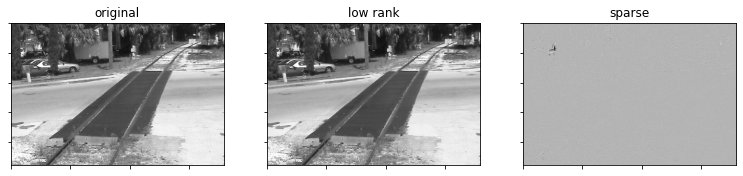

In [12]:
def do_plot(ax, img, shape):
    ax.cla()
    ax.imshow(img.reshape(shape), cmap="gray")
    ax.set_xticklabels([])
    ax.set_yticklabels([])


fig, axes = plt.subplots(1, 3, figsize=(13, 4))
for i in range(len(M)):
    do_plot(axes[0], M[i], shape)
    axes[0].set_title("original")
    do_plot(axes[1], L[i], shape)
    axes[1].set_title("low rank")
    do_plot(axes[2], S[i], shape)
    axes[2].set_title("sparse")
    fig.savefig(f"output1/frame{i}.png")

(288, 936, 3)


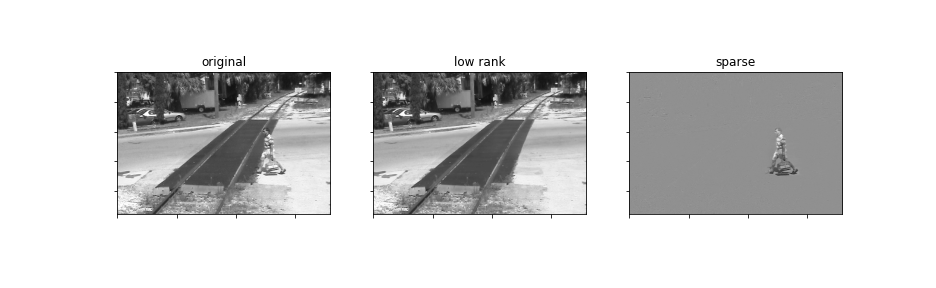

In [13]:
stacked_img = cv2.imread('output1/frame113.png')

print(stacked_img.shape)
h, w = stacked_img.shape[:2]

cv2_imshow(stacked_img)

## sort in the correct order

In [15]:
def atoi(text):  
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)',text) ]

sorted_glob = sorted(glob.glob('output1/frame*.png'),key=natural_keys)

## create video from frames

In [16]:
# fourcc = cv2.VideoWriter_fourcc(*'XVID')
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

out = cv2.VideoWriter('output_video.mp4', fourcc, 20.0, (w,h))

for filename in sorted_glob:
    img = cv2.imread(filename)
    out.write(img)

out.release()

## show all frames

In [ ]:
# cap = cv2.VideoCapture('output_video.mp4')
# while cap.isOpened():
#     ret, image = cap.read()

#     if not ret:
#       break

#     cv2_imshow(image)

#     cv2.waitKey(1) & 0xff

# cv2.destroyAllWindows()
# cap.release()